## Physics-Informed Neural Network
인공신경망을 통해 미분방정식의 해 찾기   
미분방정식에서 sample된 data 없이 미분방정식을 만족하는지 여부 (Physical Loss), 경계조건 만족 여부 (Data Loss)를 오차로 사용

#### Simple Harmonic Oscillator
1차원 단순조화진동 $\frac{d^2 f}{dt^2}+\omega^2 f = 0$에 대해 적용

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1,100)
        self.fc2 = nn.Linear(100,50)
        self.fc3 = nn.Linear(50,20)
        self.fc4 = nn.Linear(20,1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.tanh(x)
        x = self.fc4(x)
        return x

In [4]:
def ploss(model, ode, t):
    f = model(t)
    df = torch.autograd.grad(f, t, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    d2f = torch.autograd.grad(df, t, grad_outputs=torch.ones_like(df), create_graph=True)[0]
    return torch.mean(ode(f,df,d2f)**2)

In [5]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
data_points = torch.linspace(0,2,100).reshape(-1,1)
pde_points = torch.linspace(0,4,1000,requires_grad=True).reshape(-1,1)

In [7]:
for epoch in range(1,5001):
    optimizer.zero_grad()
    pde_loss = ploss(model,lambda f,df,d2f:d2f+16*f, pde_points)
    pred = model(data_points)
    data_loss = nn.MSELoss()(pred, torch.cos(4*data_points))

    loss = pde_loss*5*1e-3 + data_loss
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 1000, Loss: 0.038915425539016724
Epoch 2000, Loss: 0.02413889393210411
Epoch 3000, Loss: 0.012470923364162445
Epoch 4000, Loss: 0.007738990243524313
Epoch 5000, Loss: 0.0009289204026572406


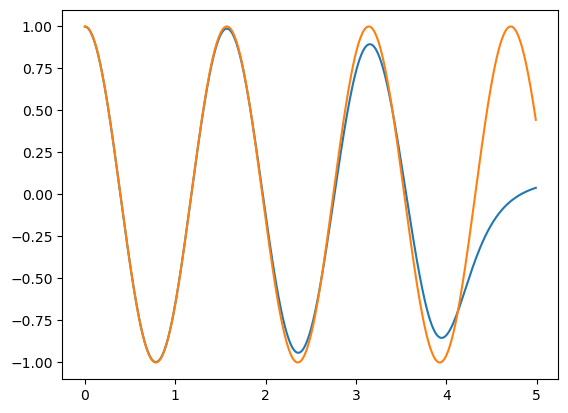

In [8]:
import matplotlib.pyplot as plt
x = torch.tensor([1/100*i for i in range(500)]).reshape(-1,1)
y = model(x).detach()
plt.plot(x,y)
plt.plot(x,torch.cos(4*x))

#### 2D Laplace Equation
$[-1,1]\times[-1,1]$에서 $x=-1,x=1,y=-1,y=1$ 디리클레 경계조건이 주어진 라플라스 방정식에 대해 적용

In [9]:
import torch
from torch import nn
from torch import optim

In [10]:
class LaplacePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2,30)
        self.fc2 = nn.Linear(30,30)
        self.fc3 = nn.Linear(30,30)
        self.fc4 = nn.Linear(30,30)
        self.fc5 = nn.Linear(30,1)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        x = self.tanh(x)
        x = self.fc4(x)
        x = self.tanh(x)
        x = self.fc5(x)
        return x

In [11]:
def ploss(model, xy):
    f = model(xy)
    grad_f = torch.autograd.grad(f, xy, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    f_x,f_y = grad_f[:,0],grad_f[:,1]
    f2_x =  torch.autograd.grad(f_x, xy, grad_outputs=torch.ones_like(f_x), create_graph=True)[0][:,0]
    f2_y =  torch.autograd.grad(f_y, xy, grad_outputs=torch.ones_like(f_y), create_graph=True)[0][:,1]
    return torch.mean((f2_x+f2_y)**2)

In [12]:
data_points = torch.cat((
    torch.stack((-torch.ones(100), torch.rand(100) * 2 - 1), dim=1),
    torch.stack((torch.ones(100), torch.rand(100) * 2 - 1), dim=1),
    torch.stack((torch.rand(100) * 2 - 1, -torch.ones(100)), dim=1),
    torch.stack((torch.rand(100) * 2 - 1, torch.ones(100)), dim=1)
))
pde_points = torch.stack((torch.rand(2000) * 2 - 1, torch.rand(2000) * 2 - 1),dim=1)
data_points.requires_grad = True
pde_points.requires_grad = True

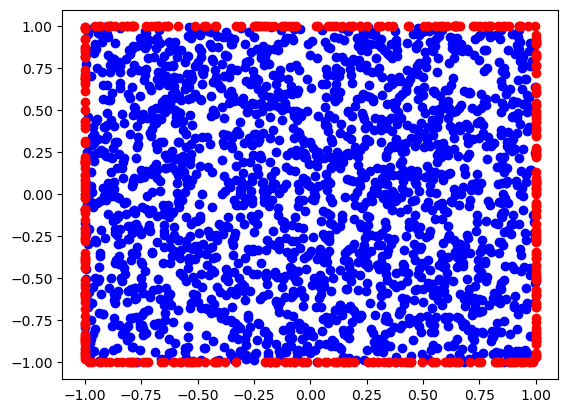

In [13]:
import matplotlib.pyplot as plt
plt.scatter(pde_points.detach()[:,0], pde_points.detach()[:,1], color='blue')
plt.scatter(data_points.detach()[:,0], data_points.detach()[:,1], color='red')

In [16]:
l, r, t, b = 0, 0, 1, 1
def getBC(row):
    if row[0]==1:
        return r
    if row[0]==-1:
        return l
    if row[1]==1:
        return t
    if row[1]==-1:
        return b

In [19]:
model = LaplacePINN()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(1,10001):
    optimizer.zero_grad()
    pde_loss = ploss(model,pde_points)
    data_loss = nn.MSELoss()(model(data_points), torch.tensor([[getBC(i)] for i in data_points], dtype=torch.float))

    loss = pde_loss*5*1e-3 + data_loss
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 1000, Loss: 0.09017235785722733
Epoch 2000, Loss: 0.04930169880390167
Epoch 3000, Loss: 0.045097850263118744
Epoch 4000, Loss: 0.04244987294077873
Epoch 5000, Loss: 0.0368957594037056
Epoch 6000, Loss: 0.021603750064969063
Epoch 7000, Loss: 0.009447612799704075
Epoch 8000, Loss: 0.0045847767032682896
Epoch 9000, Loss: 0.001840169308707118
Epoch 10000, Loss: 0.000957913463935256


In [20]:
import numpy as np
u = np.zeros((100, 100))

u[:, 0] = b
u[:, -1] = t
u[0, :] = l
u[-1, :] = r

for iteration in range(5000):
    u_old = u.copy()

    if iteration%1000==0:
        print(f'iteration {iteration}')

    for i in range(1, 99):
        for j in range(1, 99):
            u[i, j] = 0.25 * (u_old[i+1, j] + u_old[i-1, j] + u_old[i, j+1] + u_old[i, j-1])

iteration 0
iteration 1000
iteration 2000
iteration 3000
iteration 4000


Locator attempting to generate 1001 ticks ([0.0, ..., 1.0]), which exceeds Locator.MAXTICKS (1000).


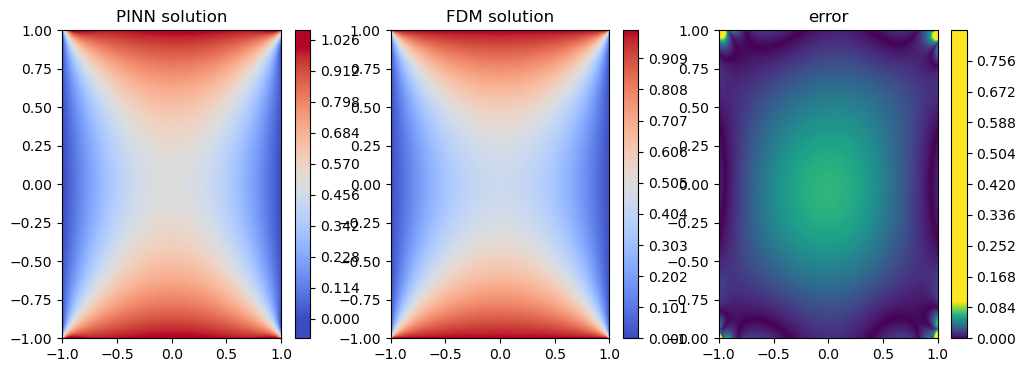

In [34]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)

with torch.no_grad():
    z = model(torch.tensor(np.c_[X.ravel(), Y.ravel()], dtype=torch.float)).numpy()

Z = z.reshape(X.shape)

fig, axes = plt.subplots(1, 3, figsize=(12,4))
cf1 = axes[0].contourf(X, Y, Z, cmap='coolwarm', levels=1000, vmin=0, vmax=1)
axes[0].set_title('PINN solution')
fig.colorbar(cf1, ax=axes[0])
cf2 = axes[1].contourf(X, Y, u.T, cmap='coolwarm', levels=1000, vmin=0, vmax=1)
axes[1].set_title('FDM solution')
fig.colorbar(cf2, ax=axes[1])
cf2 = axes[2].contourf(X, Y, abs(Z-u.T), cmap='viridis', levels=1000, vmin=0, vmax=0.1)
axes[2].set_title('error')
fig.colorbar(cf2, ax=axes[2])